In [1]:
#ViT
import numpy as np
import pandas as pd
from memory_profiler import memory_usage

import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import timm

from sklearn.model_selection import train_test_split
#from transformers import ViTFeatureExtractor, ViTForImageClassification

import random
from PIL import Image, ImageOps
from astropy.io import fits
from astropy.table import Table
from astropy.visualization import make_lupton_rgb
import matplotlib.pyplot as plt
plt.style.use('dark_background')

#If using script on terminal
#from tqdm import tqdm
from tqdm.notebook import tqdm

In [2]:
num_workers = 0
script = False

transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

model = timm.create_model("vit_base_patch16_224", pretrained=True)
path = 'jx_vit_base_p16_224-80ecf9dd.pth'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [3]:
class ImageDataset(Dataset):
    """Dataset of Images, Data and Labels"""

    def __init__(self, images, data, labels, transform=None):
        """
        Create a PyTorch dataset from an array of images
		and an array of labels
        """
        super().__init__()
        self.images = images
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #return python image given the index
        image = self.images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        label = self.labels[idx]
        data_point = self.data.iloc[idx].to_dict()
        sample = {'image': self.transform(new_image), 'label': label, 'img': image, 'data': data_point}
        return sample
    
    def normalize_image(self, image):
        image_g = (image[0]-np.mean(image[0]))/ np.std(image[0])
        image_r = (image[1]-np.mean(image[1]))/ np.std(image[1])
        image_i = (image[2]-np.mean(image[2]))/ np.std(image[2])

        image_g = (image_g-np.min(image_g))/ (np.max(image_g) - np.min(image_g))
        image_r = (image_r-np.min(image_r))/ (np.max(image_r) - np.min(image_r))
        image_i = (image_i-np.min(image_i))/ (np.max(image_i) - np.min(image_i))
        return(image_i, image_r, image_g)
    
    def plot_image(self, idx):
        image = images[idx]
        new_image = np.empty((3, 45, 45))
        new_image[0], new_image[1], new_image[2] =  self.normalize_image(image)
        new_image = new_image.transpose(1,2,0)
        new_image = Image.fromarray(np.uint8(255*new_image)).convert("RGB")
        #new_image = Image.fromarray(np.uint16(255*new_image)).convert("RGB")
        
        plt.figure(figsize=(12,4)) 
        
        plt.subplot(1,2,1)
        plt.imshow(np.asarray(new_image))
        plt.axis('off')
        
        plt.subplot(1,2,2)
        rgb = make_lupton_rgb(image[2], image[1], image[0], Q=11., stretch=40.)
        plt.imshow(rgb, aspect='equal')
        plt.axis('off')
        
        plt.show()

In [4]:
def make_train_test_datasets(images, data, labels, test_size=0.2, transform=None):
    """
	Make training and testing datasets
	
	Args:
	    images: 3D array of all images
        labels: 1D array of the labels for each image
        test_size: the fraction of the images to use as the test dataset
		transform: the PyTorch transformation to apply to the data
		
	Returns
	    train_dataset: An instance of the ImageDataset Class for training
		test_dataset: An instance of the ImageDataset Class for testing
	"""

    # Shuffle and split data
    y = labels
    train_images, test_images,  train_data, test_data, train_labels, test_labels = train_test_split(
        images, data, labels, test_size=test_size, random_state=6, stratify=y)
    
    # Create a PyTorch Dataset
    return (ImageDataset(train_images, train_data,train_labels, transform=transform),
            ImageDataset(test_images, test_data, test_labels, transform=transform))

In [5]:
class ViTBase16(nn.Module):
    
    def __init__(self, n_classes, pretrained=False):
        
        super(ViTBase16, self).__init__()
        
        self.model = timm.create_model("vit_base_patch16_224", pretrained=True)
        if (pretrained):
            path = 'jx_vit_base_p16_224-80ecf9dd.pth'
            self.model.load_state_dict(torch.load(path))

        self.model.head = nn.Linear(self.model.head.in_features, n_classes)

    def forward(self, x):
        x = self.model(x)
        return x


In [6]:
model = ViTBase16(n_classes=9, pretrained=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

name = 'Experiments/exp_55/model.pt'#'model.pt'#'other.pt' 
model = torch.load(name, map_location=torch.device('cpu'))

In [7]:
# Real lenses
path_cutouts = '/Users/jimenagonzalez/research/DSPL/Searching-double-lenses/real_lenses/Jack_Y6/Cutouts/'
hdu_list = fits.open(path_cutouts + 'Jack_Y6.fits')
lenses = hdu_list[1].data.astype(np.float32)
data_pos = hdu_list[2].data
data_pos = Table(data_pos)
data_pos = data_pos.to_pandas()
#data_pos = data_pos.drop(['TILENAME', 'Candidate'], axis=1)
columns_data = data_pos.columns
hdu_list.close()

dataset = ImageDataset(lenses, data_pos, np.zeros(len(lenses), dtype = np.int64), transform=transform)
print(len(dataset))

246


In [8]:
def search(dataset):
    prob_list = []
    search_loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=1, num_workers=num_workers, shuffle=True)
    images = len(categories)*[np.zeros((1,3,45,45))]
    all_data = len(categories)*[pd.DataFrame()]
    
    for i_batch, sample in enumerate(tqdm(search_loader)):
        #if(i_batch==20): break
        sample_image, sample_label, sample_img, sample_data = sample['image'], sample['label'] , sample['img'], sample['data']
        
        output = model(sample_image)
    
        prob = nn.Softmax(dim=1)(output)
        prob_list.append(prob[:,0].detach().cpu().numpy()[0])
        i = prob.argmax(dim=1)
        
        new_df = pd.DataFrame(sample_data, columns=columns_data)
        new_df['Prob'] = prob[:,i].detach()
        all_data[i] = all_data[i].append(new_df, ignore_index=True)
        images[i] = np.append(images[i], np.array(sample_img), axis = 0)
    
    for i in range(len(categories)):
        images[i] = np.delete(images[i], 0, axis = 0)
    
    return(images, all_data, prob_list)

In [9]:
categories = ['Positives', 'Rings', 'Smooth', 'Companion', 'SDSS', 'DES_spirals', 'Crowded', 'Errors', 'Most_negatives']
images, all_data, prob_list = search(dataset)

right_data = all_data[0]
wrong_data = pd.DataFrame(columns=columns_data)

for i in range(len(all_data)):
    if(i == 0): continue
    wrong_data = wrong_data.append(all_data[i])

  0%|          | 0/246 [00:00<?, ?it/s]

/Users/jimenagonzalez/Software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


In [11]:
#Default threshold of probability
print('Total: ' + str(len(lenses)))
print('Detected: {}, not detected: {} \n'.format(len(right_data), len(wrong_data)))

print('Not identified lenses with Einstein radius > 6: ' + str(len(wrong_data[wrong_data['einstein_radius'] > 6])))
print('Identified lenses with Einstein radius < 6: ' + str(len(right_data[right_data['einstein_radius'] <= 6])))
print(' ')

for i in range(len(images)):
    if(len(images[i])==0): continue
    num = len(all_data[i][all_data[i]['einstein_radius'] <= 6 ])
    line = 'Labeled as {}: {}'.format(categories[i], len(images[i]))
    print(line, '| ' + str(num))

    
print(' ')
ind = right_data[right_data['Prob'] > 0.949].index
print('Detected with a 0.949 threshold: '+ str(len(ind)))
ind = right_data[right_data['Prob'] > 0.974].index
print('Detected with a 0.974 threshold: '+ str(len(ind)))

Total: 246
Detected: 97, not detected: 149 

Not identified lenses with Einstein radius > 6: 103
Identified lenses with Einstein radius < 6: 81
 
Labeled as Positives: 97 | 81
Labeled as Rings: 1 | 1
Labeled as Smooth: 5 | 5
Labeled as Companion: 7 | 7
Labeled as SDSS: 3 | 2
Labeled as Crowded: 14 | 14
Labeled as Errors: 1 | 0
Labeled as Most_negatives: 118 | 17
 
Detected with a 0.949 threshold: 78
Detected with a 0.974 threshold: 77


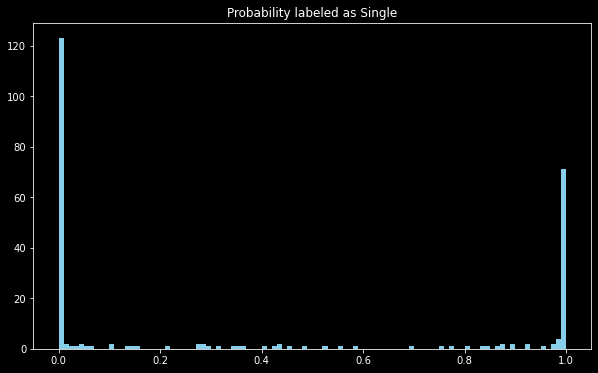

In [12]:
plt.figure(figsize=(10,6))
plt.title('Probability labeled as Single')
plt.hist(prob_list, 100, color = "skyblue")
plt.show()

In [13]:
def write_fit_file(name, x, data):
    my_types = {'COADD_OBJECT_ID': int, 'TILENAME': str, 'HPIX_16384': int, 'HPIX_4096': int,
       'DNF_ZMEAN_SOF': float, 'RA': float, 'DEC': float, 'FLUX_RADIUS_G': float, 'FLUX_RADIUS_R': float,
       'FLUX_RADIUS_I': float, 'FLUX_RADIUS_Z': float, 'KRON_RADIUS': float, 'GAP_FLUX_G': float,
       'MOF_BDF_FLUX_G': float, 'MOF_PSF_FLUX_G': float, 'SOF_BDF_FLUX_G': float, 'SOF_PSF_FLUX_G': float,
       'MAG_AUTO_G': float, 'MAG_APER_4_G': float, 'MAG_APER_8_G': float, 'SOF_BDF_G_1': float,
       'SOF_BDF_G_2': float, 'IMAFLAGS_ISO_G': float, 'IMAFLAGS_ISO_R': float, 'IMAFLAGS_ISO_I': float,
       'IMAFLAGS_ISO_Z': float, 'rank': int, 'num_sources': int, 'num_lenses': int, 'mem_match_id': int,
       'einstein_radius': float, 'einstein_radius_err': float, 'ACT': int, 'BBNA': int, 'BNA': int, 'TI': int,
       'RNA': int, 'RNA2': int, 'redM': float, 'redM_missed': float, 'SPTPol': float, 'Prob': float}
    data = data.astype(my_types)
    
    primary = fits.PrimaryHDU()
    image = fits.ImageHDU(x, name="IMAGE")
    table_data = Table.from_pandas(data)
    table = fits.BinTableHDU(data = table_data)
    hdu_list = fits.HDUList([primary, image, table])
    hdu_list.writeto(name + '.fits', overwrite=True)   
    hdu_list.close()

In [14]:
def make_plot_all(objects, data):
    
    for i in range(len(objects)):
        if(i%4 == 0):
            plt.figure(figsize=(12,8))
            for j in range(4):
                if(i+j > len(objects)-1): break
                plt.subplot(1,4,j+1)
                title = '{:.3f}'.format(data['Prob'].values[i+j])
                print(data['COADD_OBJECT_ID'].values[i+j])
                plt.title(title)
                rgb = make_lupton_rgb(objects[i+j][2], objects[i+j][1], objects[i+j][0], Q=11., stretch=40.)
                plt.imshow(rgb, aspect='equal')
                plt.xticks([], [])
                plt.yticks([], []) 
            plt.show()

Not identified with E < 6 

Rings
1293454009


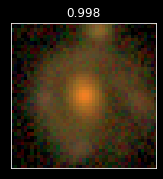

 
Smooth
1543203779
1100499372
1511180764
1098080005


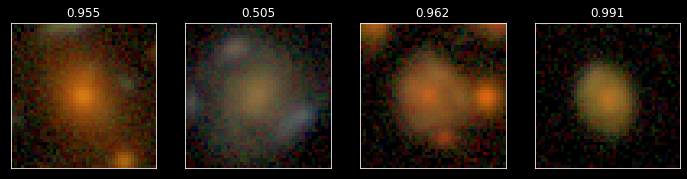

1397786541


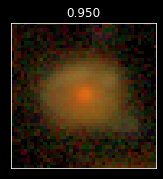

 
Companion
1095012420
1515924344
948472502
1096272141


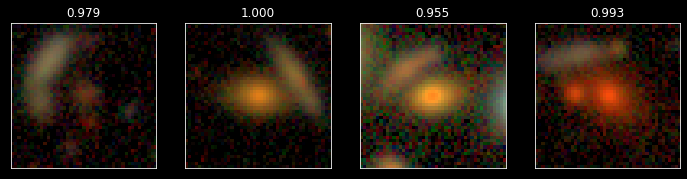

1099199002
1436738189
1424382704


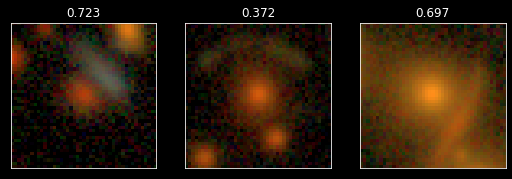

 
SDSS
1010940448
1095104928


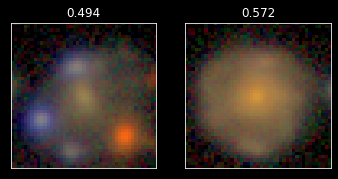

 
DES_spirals
 
Crowded
1098825401
1613622977
1150981093
931716591


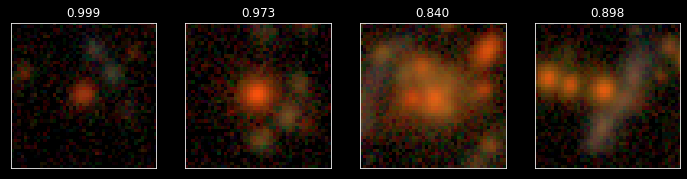

1605209704
1090875242
1237074304
906297047


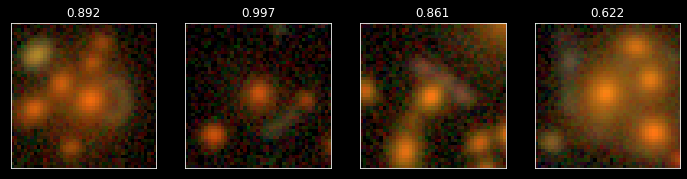

1087586642
940222725
1380490997
1412479687


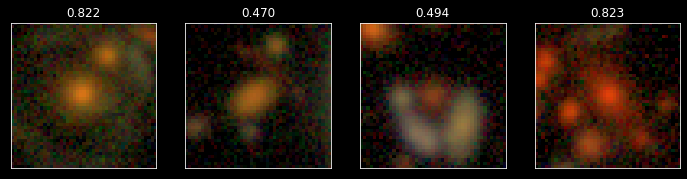

1237872703
1544354650


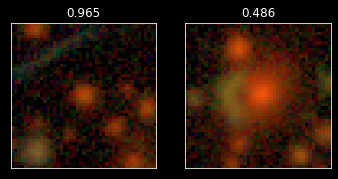

 
Errors
 
Most_negatives
1473678153
1340791460
1238888461
967663413


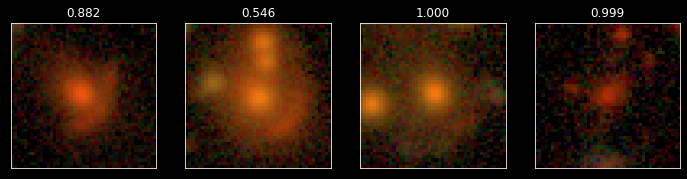

1616237624
1556812908
1492389862
1076469675


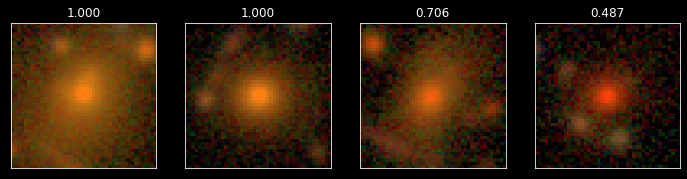

1032611021
1408480079
1132128416
1193389759


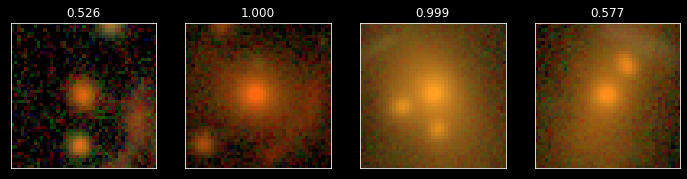

1230216549
1555408224
1176577162
891448380


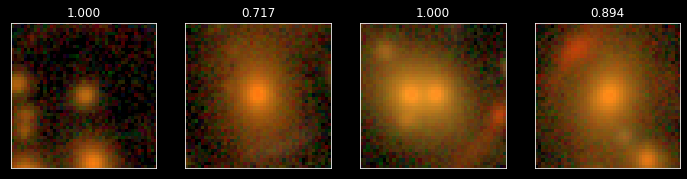

940889646


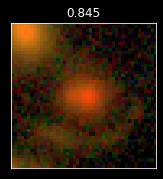

In [33]:
#Not identified with E < 6
print('Not identified with E < 6 \n')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images[i]) == 0): 
        print(' ')
        continue
    ind = all_data[i][all_data[i]['einstein_radius'] <= 6 ].index
    make_plot_all(images[i][ind], all_data[i].loc[ind])
    print(' ')

Identified with E < 6 

Positives
1406154832
1301081250
1175885227
1132438466


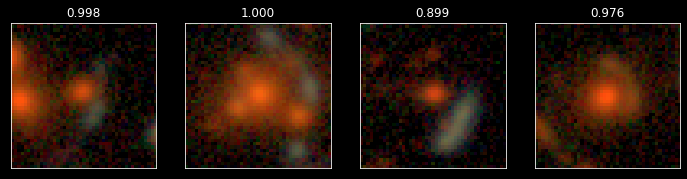

1309246601
1224505431
1120481923
1471530329


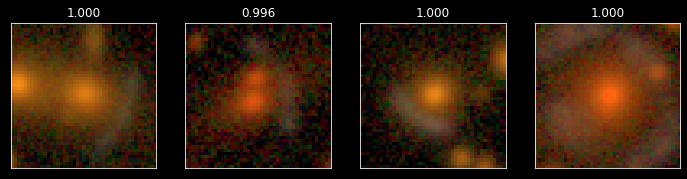

1079483534
1603413407
1075990880
1555731785


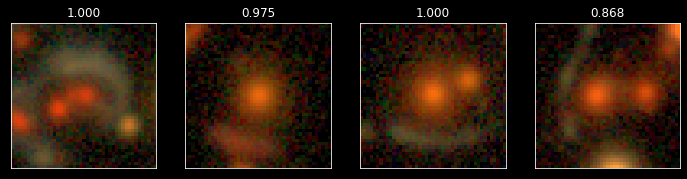

1431464188
1059844041
1315897713
1177118232


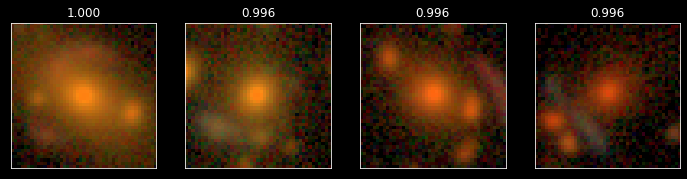

1460366855
958711616
1539117960
1226283999


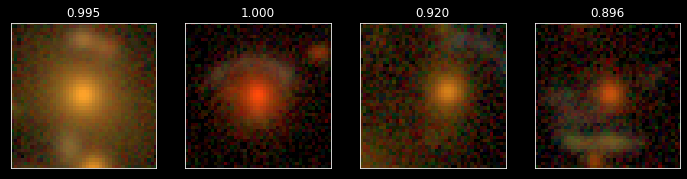

1235391858
960634096
1179738251
1344635131


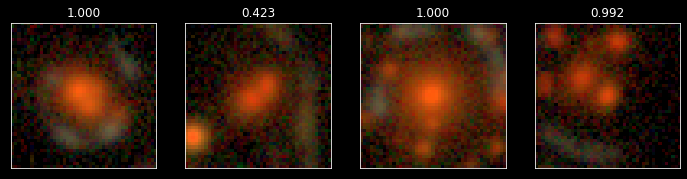

1425127607
1535218994
1042572859
1457701647


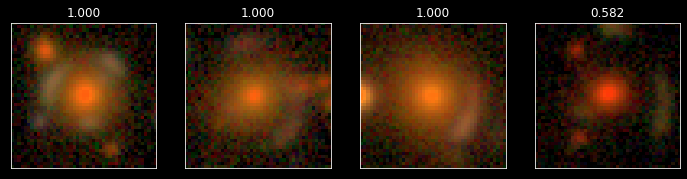

1243683190
1186271916
1215585225
943336674


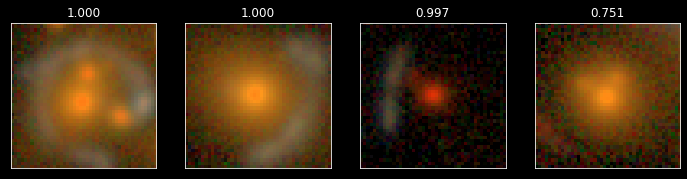

1380201297
1015396778
1561967167
1429256248


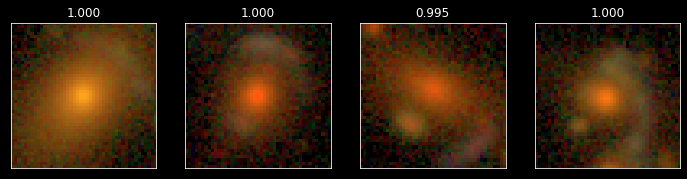

1237527717
1354965854
1410370257
1618265499


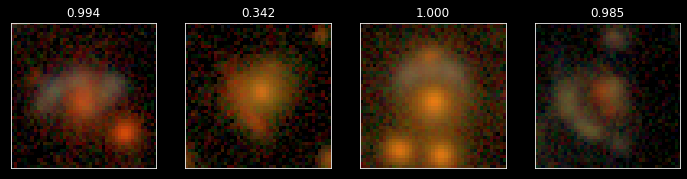

1254690304
1320090903
1346316177
1307294028


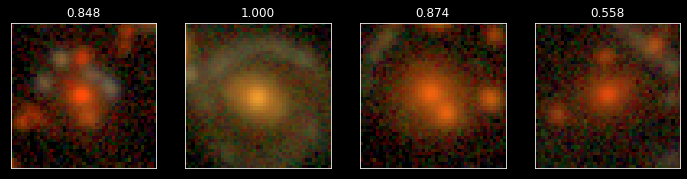

1248376226
1188402103
1027961497
1132666004


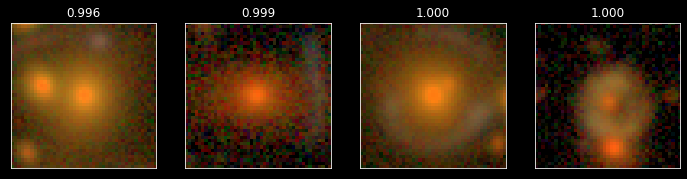

1136960821
945275549
1297969687
1544871292


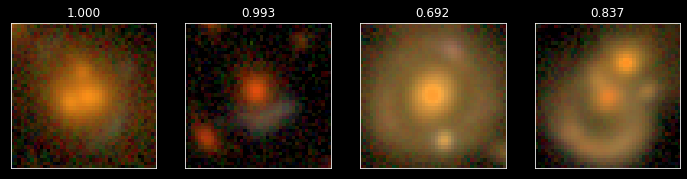

1334070236
1194748640
1014987031
1234418937


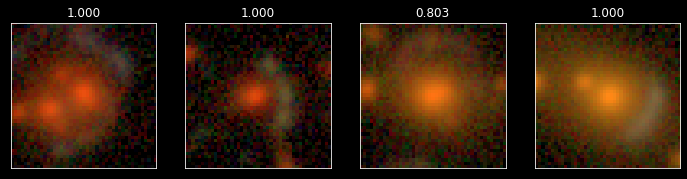

1065852196
1281613121
1282283042
1341473830


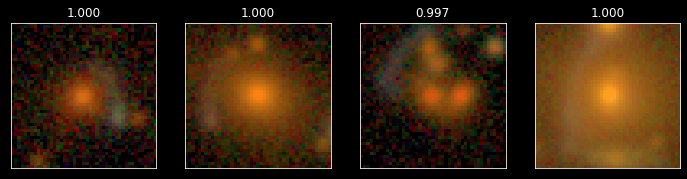

1370519642
1196484135
1095073803
1253518858


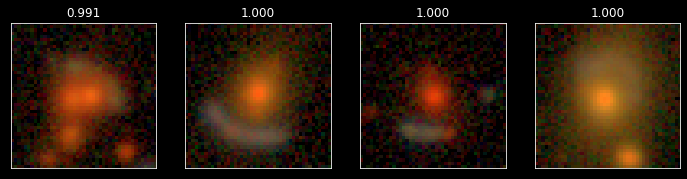

1005730815
1193586965
1065068829
1560467285


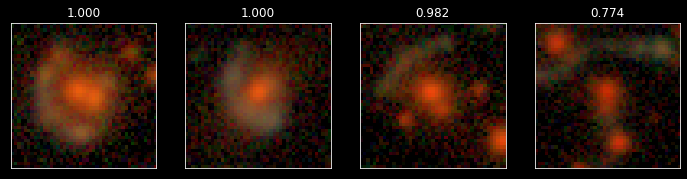

1466200592
996824828
1129249726
918844670


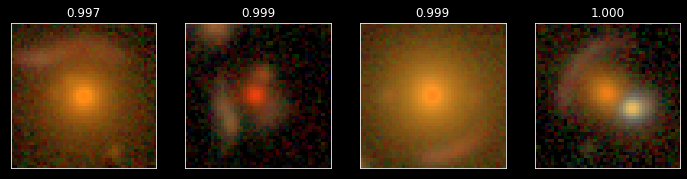

1438681779
919882930
1139453426
1033271849


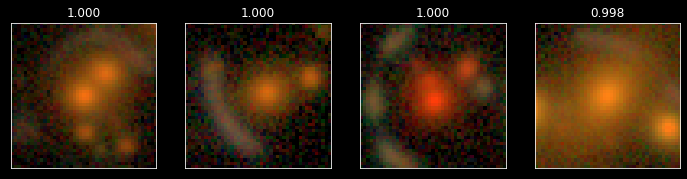

1163516688
942145369
1541861374
1262885787


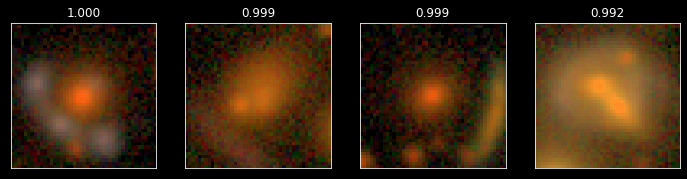

1008494220


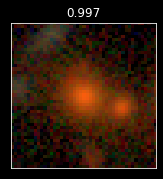

In [32]:
#Identified with E < 6
print('Identified with E < 6 \n')
print(categories[0])
ind = all_data[0][all_data[0]['einstein_radius'] <= 6 ].index
make_plot_all(images[0][ind], all_data[0].iloc[ind])

Not identified with E > 6 

Rings
 
Smooth
 
Companion
 
SDSS
1302913411


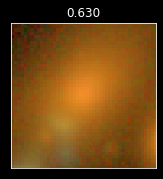

 
DES_spirals
 
Crowded
 
Errors
875861728


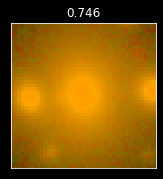

 
Most_negatives
1600288437
1033333108
968514872
1022749274


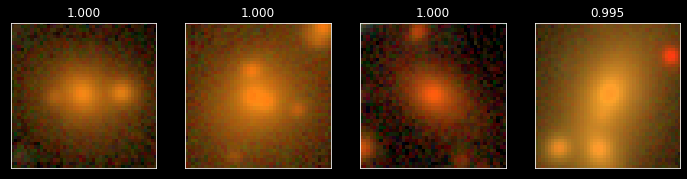

1310351225
1372004130
1022753178
935500908


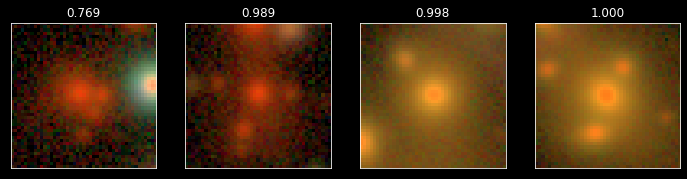

1326662771
1104152493
1553993296
1075010553


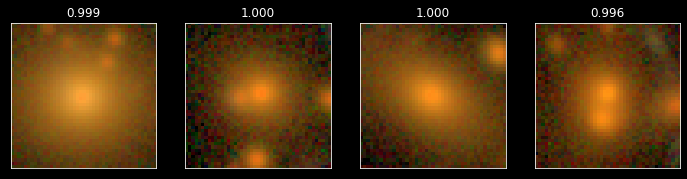

1096108699
1130037119
1096106638
890123132


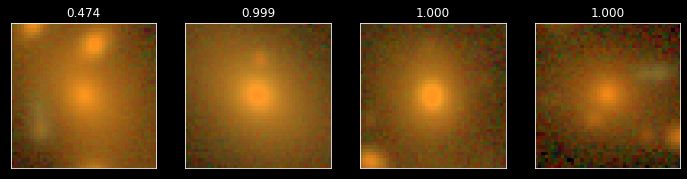

1262815086
929464065
1211759750
1018373612


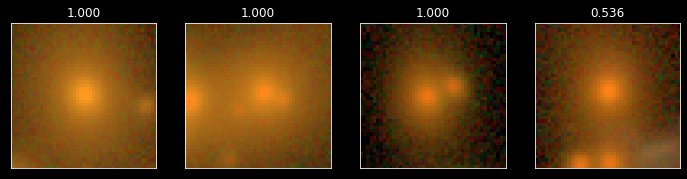

1620789333
1512302706
912239998
1080468439


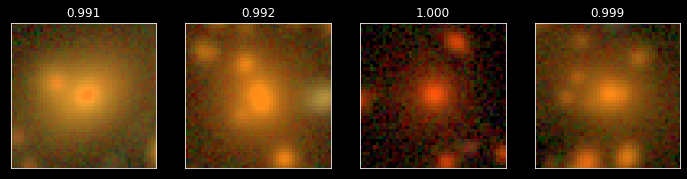

1205235466
1478719341
1135449475
1006398298


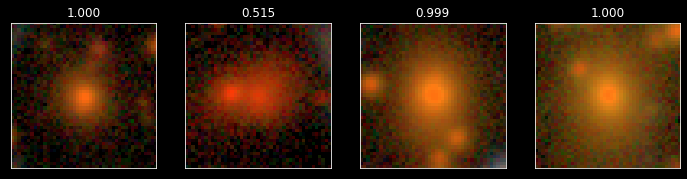

981335505
1369627471
1591618397
1243894857


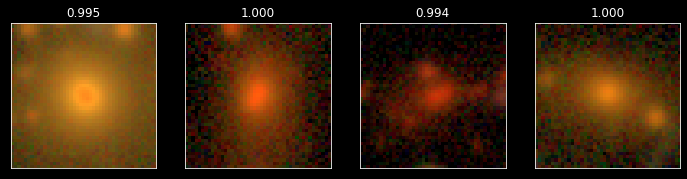

1518678765
1051146741
1039192988
1444189303


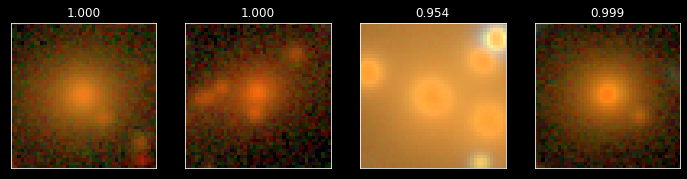

1097449211
1598223655
880775998
1075825038


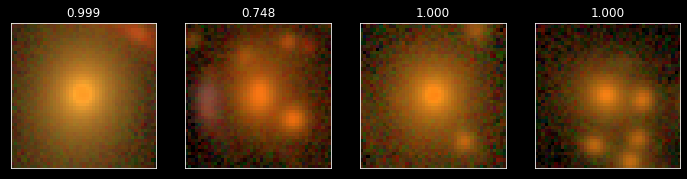

1092532196
894391144
1500313463
1269458842


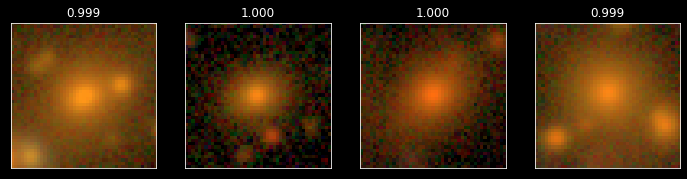

1432368460
1116860474
1329591757
1574006205


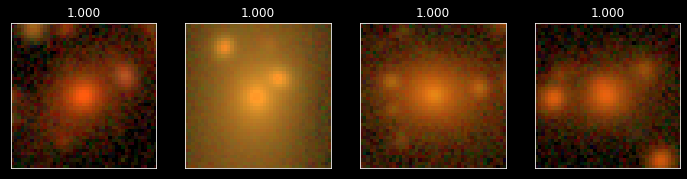

1525378628
1581430084
1320102858
926990988


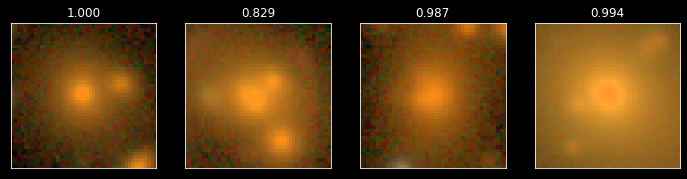

1339237461
1100056641
992157466
1311519346


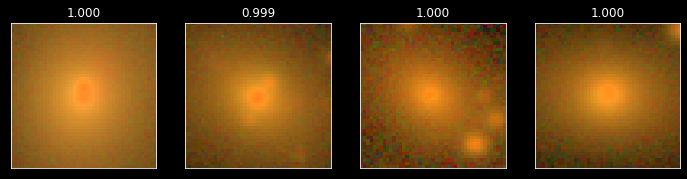

1337694534
1311859703
1276467865
1182667355


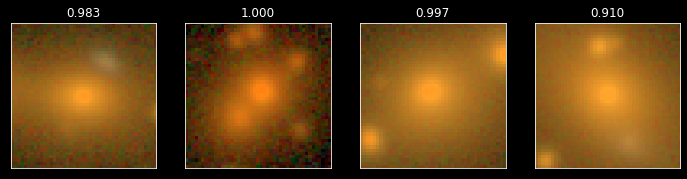

1005190830
1497065303
1196267668
1019075491


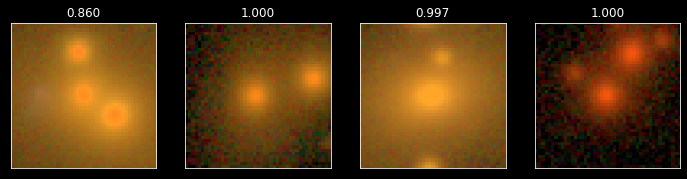

1432853769
1604160427
1405862851
1532721542


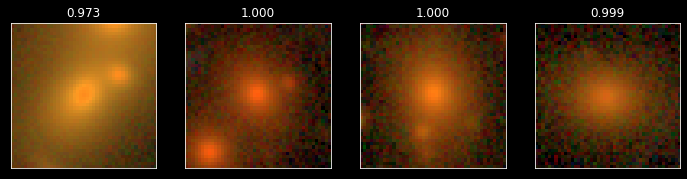

1312605504
874430227
1448395045
873960975


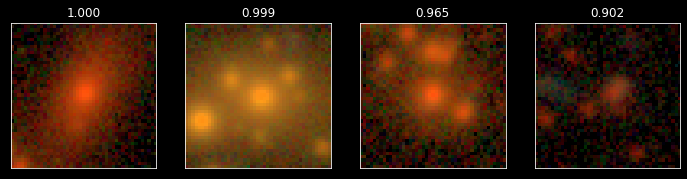

1539815370
1096356557
1131903141
1144014836


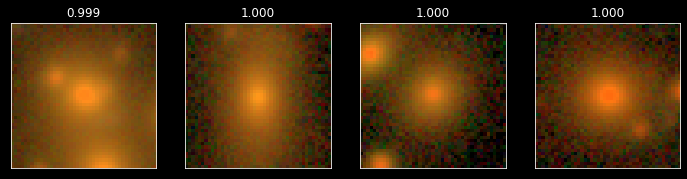

1579393120
1286324573
1417005344
1522920500


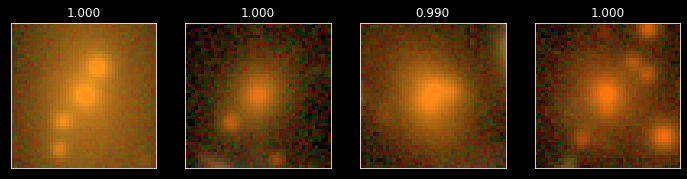

1267131914
1365603963
1344840821
1585989929


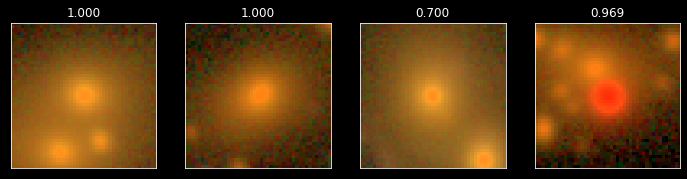

1413959827
1041564142
1445405684
1559105198


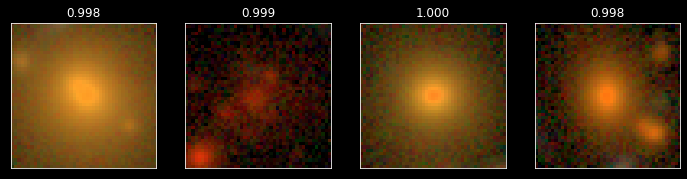

1098063467
1505761179
1389753930
1204581428


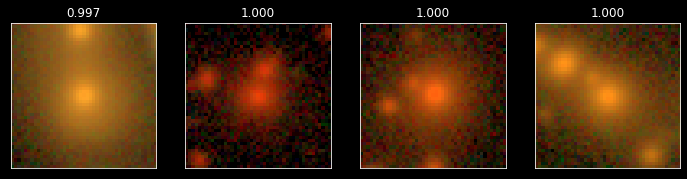

985651579
1253220108
1069554405
1227352718


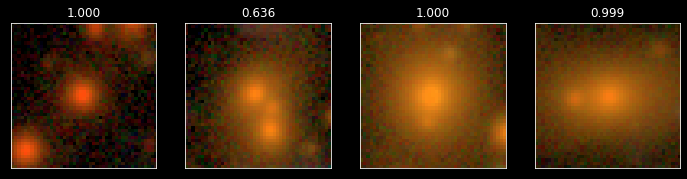

877696474
1404219210
977331342
1432395652


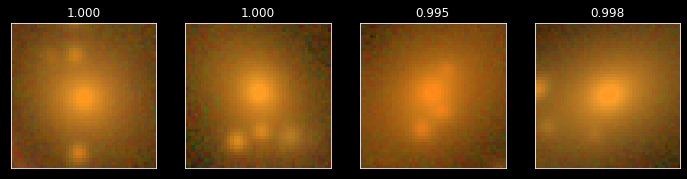

1011335771


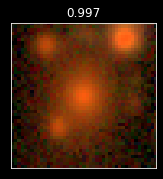

In [24]:
#Not identified with E > 6
print('Not identified with E > 6 \n')
for i in range(1, len(categories)):
    print(categories[i])
    if(len(images[i]) == 0): 
        print(' ')
        continue
    ind = all_data[i][all_data[i]['einstein_radius'] > 6 ].index
    make_plot_all(images[i][ind], all_data[i].loc[ind])
    print(' ')

Identified with E > 6 

Positives
1333189566
912635250
1021262800
972522805


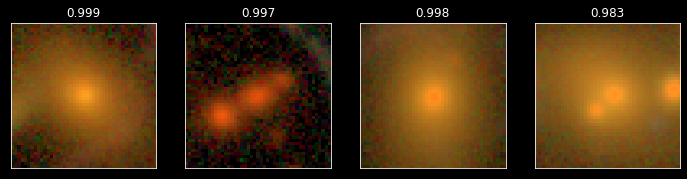

1015716039
934650347
1090651028
1123546242


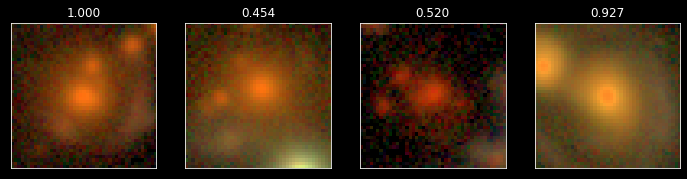

1461199109
1027060361
1395103367
1540902420


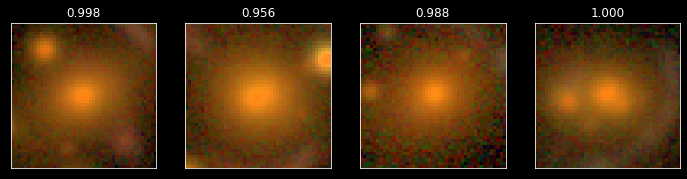

1249049816
1396458125
893678703
1048920254


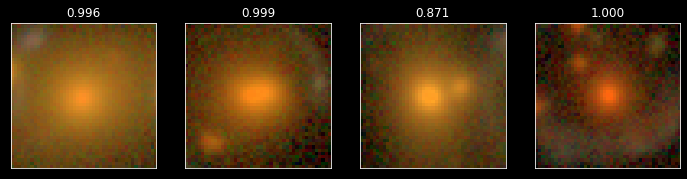

In [25]:
#Identified with E > 6
print('Identified with E > 6 \n')
print(categories[0])
ind = all_data[0][all_data[0]['einstein_radius'] > 6 ].index
make_plot_all(images[0][ind], all_data[0].iloc[ind])

In [26]:
names = ['Prob', 'einstein_radius', 'DNF_ZMEAN_SOF', 'rank', 'FLUX_RADIUS_G', 'KRON_RADIUS', 'GAP_FLUX_G',
         'MAG_AUTO_G', 'MAG_APER_4_G', 'MAG_APER_8_G', 'num_sources', 'num_lenses', 
         'einstein_radius_err']
print(len(names))
right_data = right_data[right_data['MAG_AUTO_G'] < 50]
wrong_data = wrong_data[wrong_data['MAG_AUTO_G'] < 50]

13


In [27]:
def make_histo(name):
    plt.figure(figsize=(16,5)) 

    plt.subplot(1,2,1)
    plt.title('All distribution: ' + str(name))
    data_all = np.concatenate((right_data[name], wrong_data[name]))
    plt.hist(data_all, density = True, bins = 'auto', edgecolor = 'black')
    
    
    plt.subplot(1,2,2)
    plt.title(name)
    plt.hist(right_data[name], density = True, bins = 'auto', color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
    plt.hist(wrong_data[name], density = True, bins = 'auto', color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
    plt.legend()
    
    plt.show()
        

def make_all_histos():
    for name in names:
        make_histo(name)

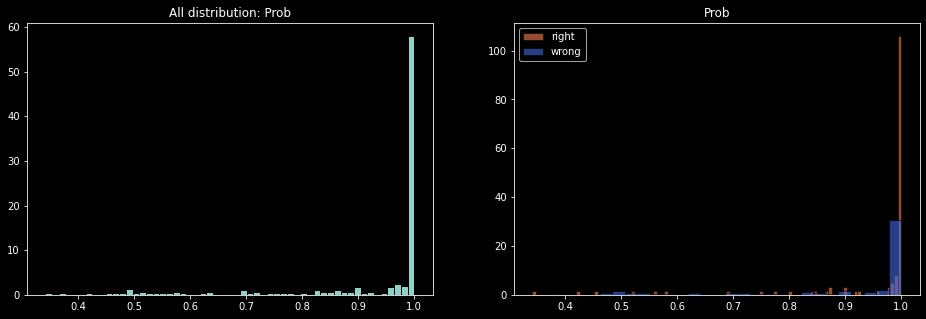

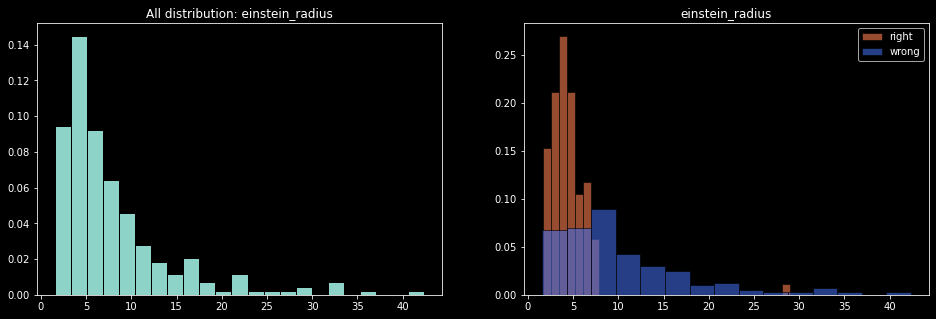

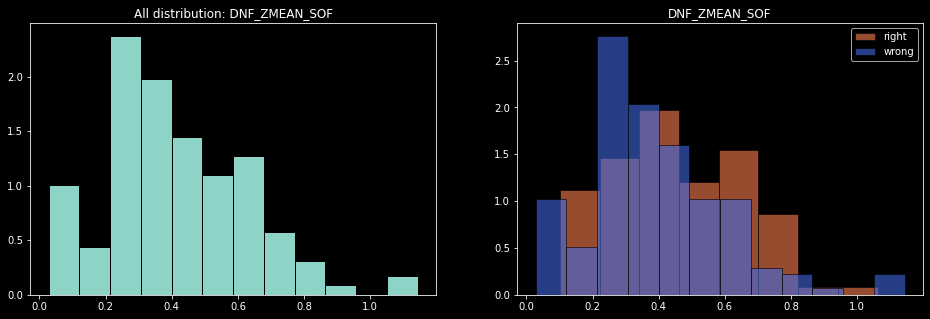

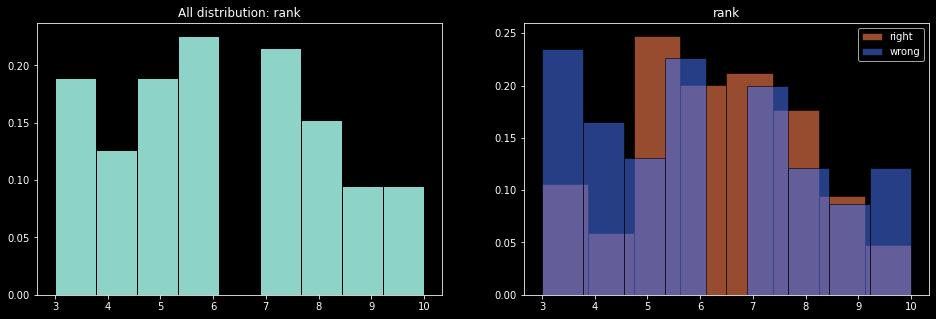

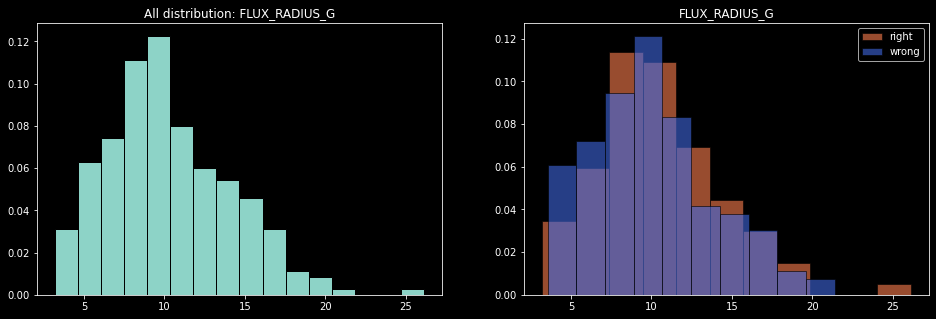

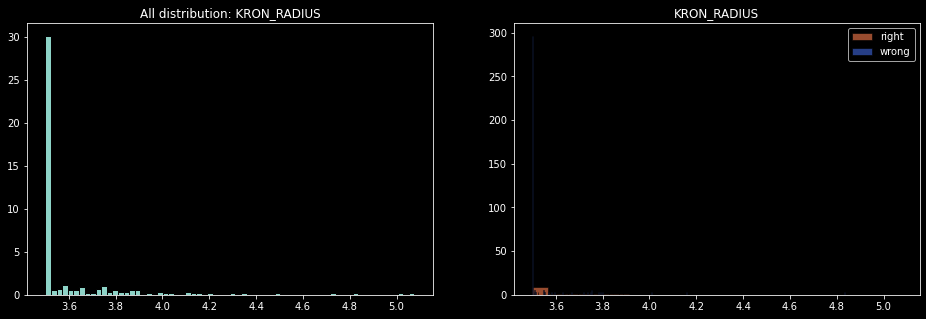

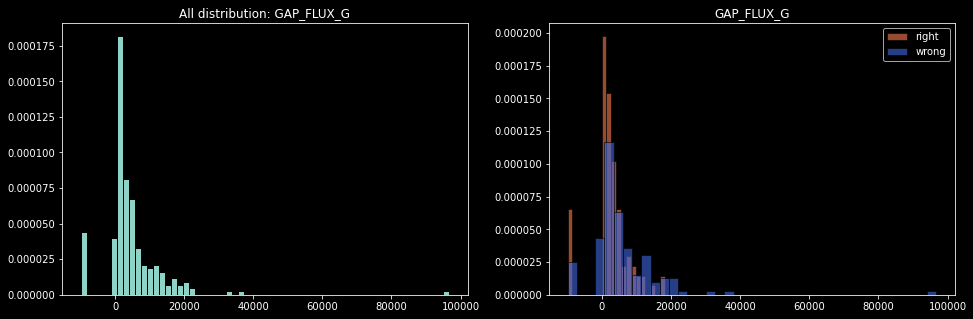

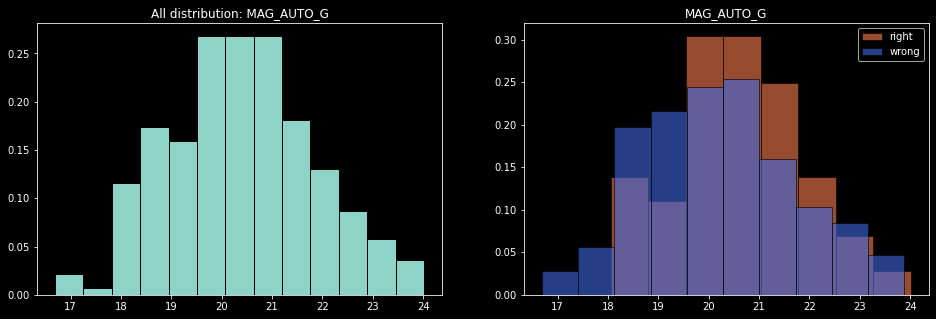

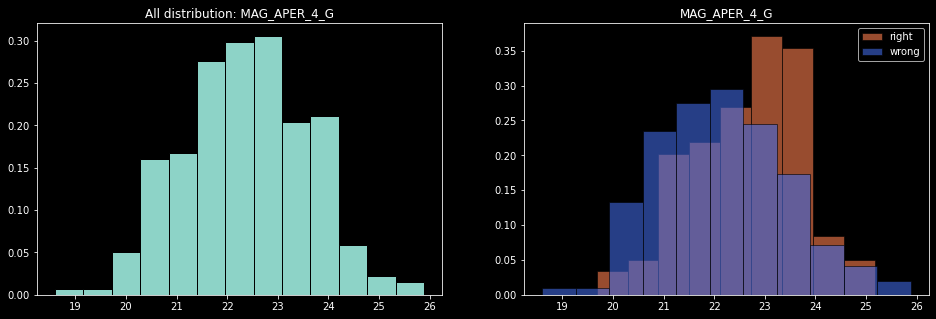

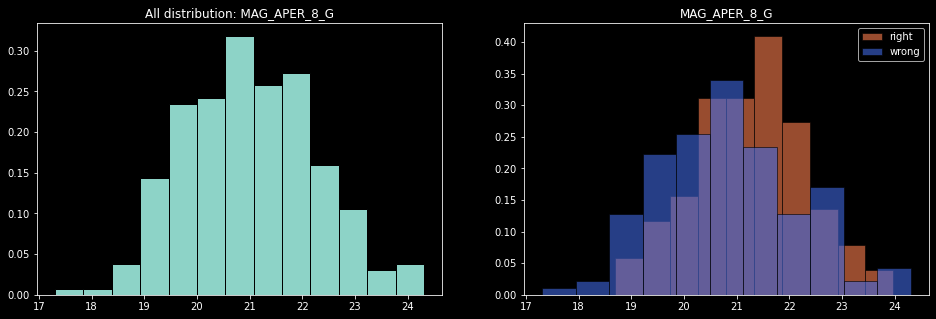

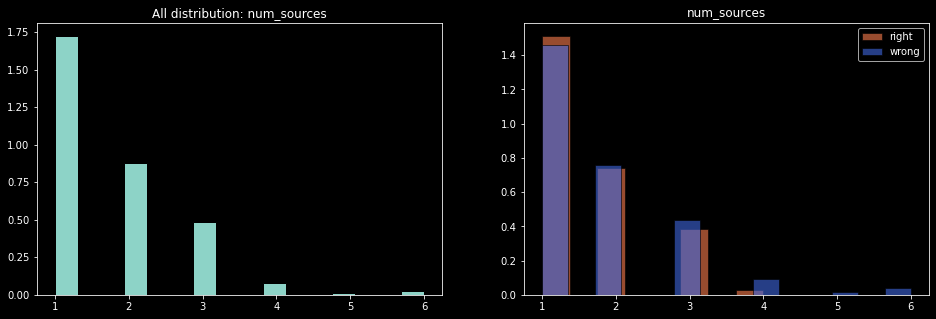

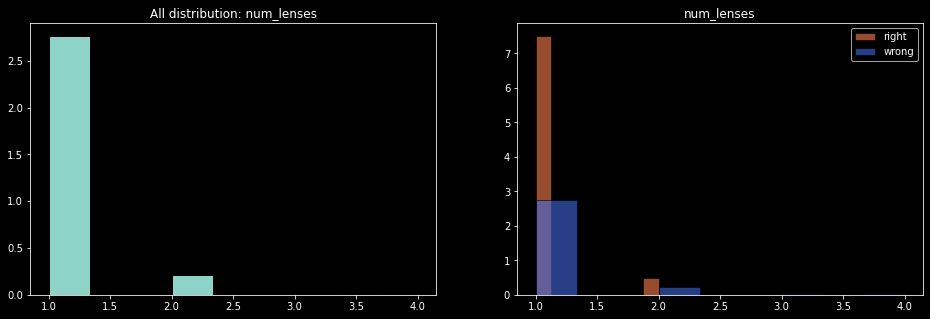

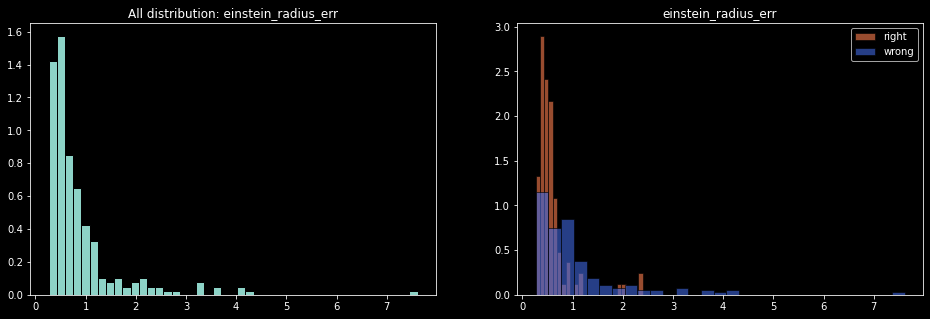

In [28]:
make_all_histos()

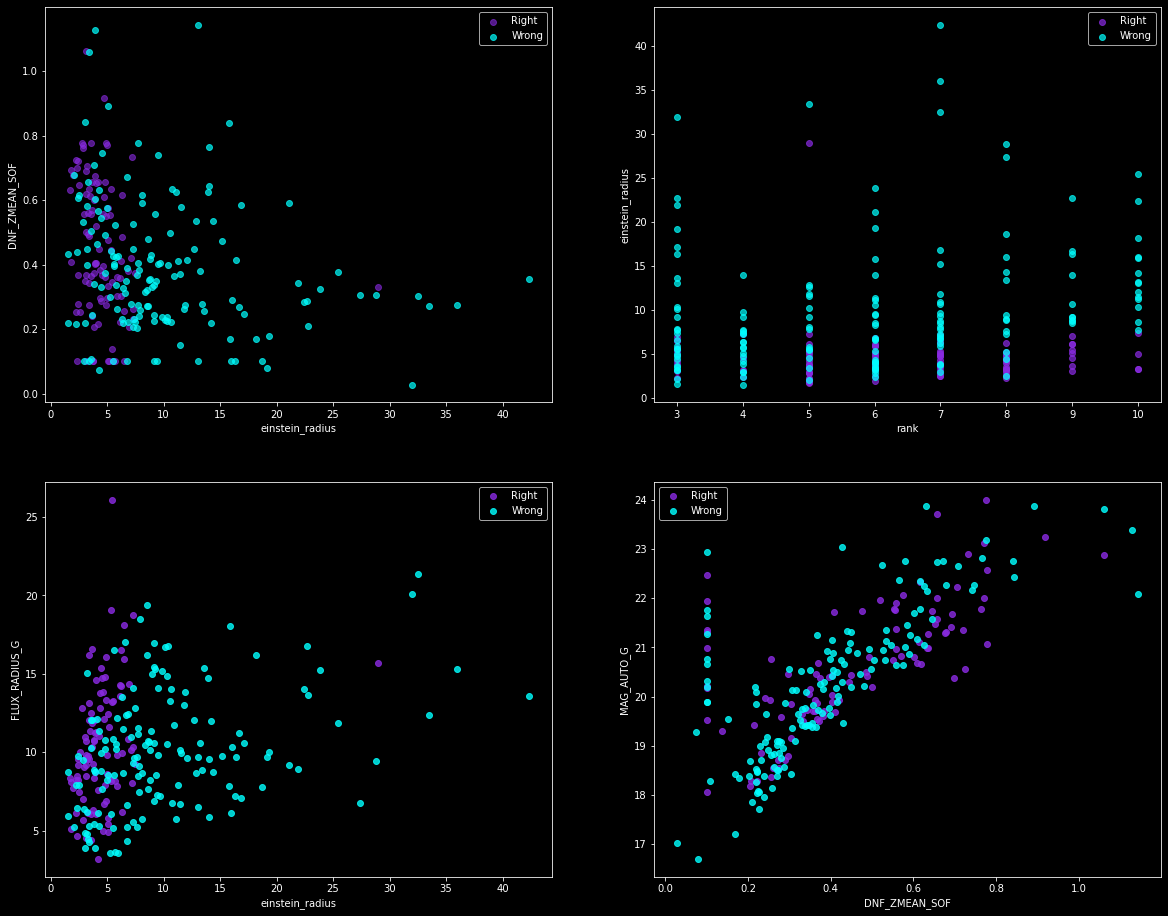

In [29]:
plt.figure(figsize=(20,16)) 

plt.subplot(2,2,1)
plt.xlabel(names[1])
plt.ylabel(names[2])
plt.scatter(right_data[names[1]], right_data[names[2]], color = 'blueviolet', alpha = 0.6, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[2]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,2)
plt.xlabel(names[3])
plt.ylabel(names[1])
plt.scatter(right_data[names[3]], right_data[names[1]], color = 'blueviolet', alpha = 0.7, label ='Right')
plt.scatter(wrong_data[names[3]], wrong_data[names[1]], color = 'cyan', alpha = 0.7, label = 'Wrong')
plt.legend()

plt.subplot(2,2,3)
plt.xlabel(names[1])
plt.ylabel(names[4])
plt.scatter(right_data[names[1]], right_data[names[4]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[1]], wrong_data[names[4]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 

plt.subplot(2,2,4)
plt.xlabel(names[2])
plt.ylabel(names[7])
plt.scatter(right_data[names[2]], right_data[names[7]], color = 'blueviolet', alpha = 0.8, label ='Right')
plt.scatter(wrong_data[names[2]], wrong_data[names[7]], color = 'cyan', alpha = 0.8, label = 'Wrong')
plt.legend() 
    
plt.show()

In [30]:
print(len(wrong_data)+len(right_data))

wrong_smaller = wrong_data[wrong_data['einstein_radius'] <= 6]
wrong_larger = wrong_data[wrong_data['einstein_radius'] > 6]
right_smaller = right_data[right_data['einstein_radius'] <= 6]
right_larger = right_data[right_data['einstein_radius'] > 6]

print(len(wrong_data), len(wrong_smaller), len(wrong_larger))
print(len(right_data), len(right_smaller), len(right_larger))

245
148 46 102
97 81 16


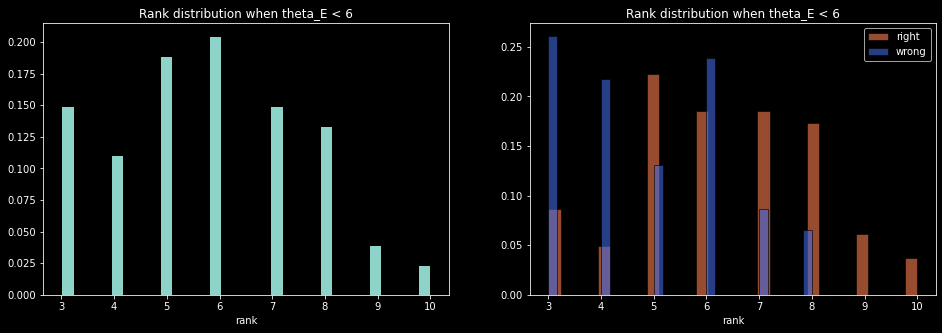

In [31]:
i=3

plt.figure(figsize=(16,5)) 

plt.subplot(1,2,1)
plt.title('Rank distribution when theta_E < 6')
plt.xlabel(names[i])
data_all = np.concatenate((right_smaller[names[i]], wrong_smaller[names[i]]))
weights = np.ones_like(data_all) / len(data_all)
plt.hist(data_all, 30, weights = weights, edgecolor = 'black')

plt.subplot(1,2,2)
plt.title('Rank distribution when theta_E < 6')
plt.xlabel(names[i])
weights = np.ones_like(right_smaller[names[i]]) / len(right_smaller[names[i]])
plt.hist(right_smaller[names[i]], 30, weights = weights, color = 'coral', alpha = 0.6, edgecolor = 'black', label='right')
weights = np.ones_like(wrong_smaller[names[i]]) / len(wrong_smaller[names[i]])
plt.hist(wrong_smaller[names[i]], 30, weights = weights, color = 'royalblue', alpha = 0.6, edgecolor = 'black', label='wrong')
plt.legend()  

plt.show()